# Lab 4 - BCC406

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Regressão Logística e Rede Neural

### Prof. Eduardo e Prof. Pedro

Objetivos:

- Aplicação de filtros em imagens por meio de convolução
- Entendimento do uso de stride, padding e pooling
- Modelagem de uma rede de convolução para o problema de rec. de face da AT&T
- Uso do VGG pr-e-treinado como um extrator de caracterĩsticas
- Uso do MobileNet pré-treinado para classificação de faces : transferência de aprenzagem
- Notebook baseado em tensorflow e Keras.

Data da entrega : 09/09 

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-LabX.pdf"
- Envie o PDF via google [FORM](https://forms.gle/71SLqseovuuc8qUB9)


# 1. Aplicando filtros e entendendo padding, stride e pooling (20pt)

## 1.1. Importando pacotes e montando o drive

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from tensorflow.keras import datasets, layers, models
import os
import skimage
from skimage import io
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread
from skimage.transform import resize

## 1.2. Carregando uma imagem

Carregue um imagem do disco, para usar como exemplo.

sample image shape:  (512, 512, 3)


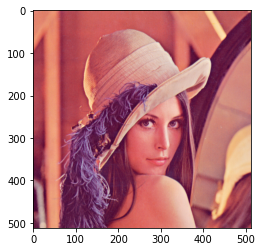

In [4]:
# carrega imagem de exemplo
sample_image = imread("/content/drive/My Drive/Lenna.png")
sample_image= sample_image.astype(float)

size = sample_image.shape
print("sample image shape: ", sample_image.shape)

plt.imshow(sample_image.astype('uint8'));

In [5]:
# veja o shape da imagem
sample_image.shape

(512, 512, 3)

## 1.3. Criando e aplicando um filtro com convolução

Utilize o tf/Keras para aplicar o filtro. Observe que nesta etapa não há necessidade de treinamento algum. O código abaixo cria 3 filtros de tamanho 5x5, e adiciona padding de forma a manter a imagem de saída (filtrada) do mesmo tamanho da imagem de entrada (padding ="same").

In [6]:
#cria um objeto sequencial com apenas uma camada de convolução do tipo tf.keras.layers.Conv2D
conv = Sequential([
    Conv2D(filters=3, kernel_size=(5, 5), padding="same",
           input_shape=(None, None, 3))
])
conv.output_shape

(None, None, None, 3)

In [7]:
conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 3)     228       
                                                                 
Total params: 228
Trainable params: 228
Non-trainable params: 0
_________________________________________________________________


In [8]:
# com TF/kertas, as convoluções esperam vetores no formato : (batch_size, dim1, dim2, dim3). Ou seja, a primeria posição é o tamanho do lote. 
# Uma imagem isolada é considerada um lote de tamanho 1, portanto, deve-se expandir mais uma dimenão do tensor.
img_in = np.expand_dims(sample_image, 0) 
img_in.shape

(1, 512, 512, 3)

Agora, pode-se aplicar a convolução. Aplique a convolução na imagem de exemplo (expandida) e verifique o tamanho da imagem resultante (img_out). Use a função predict do objeto conv para aplicar a convolução.

In [9]:
img_out = conv(img_in)
img_out.shape

TensorShape([1, 512, 512, 3])

Plote as imagens lado a lado e observe o resultado. O parâmetro "same" no padding aplica um padding automático no sentido de garantir que a saída tenha o mesmo tamanho da entrada.
Lembre-se que o padding adiciona zeros nas bordas da imagem, antes da aplicação da convolução.

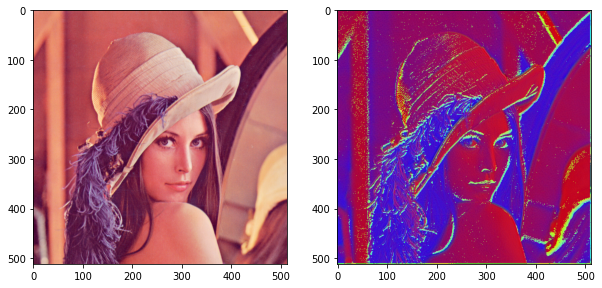

In [10]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
ax1.imshow(img_out[0].numpy().astype('uint8'));

Repita o mesmo procedimento, trocando padding de 'same' para 'valid', usando apenas um filtro.

In [11]:
conv2 = Sequential([
    Conv2D(filters=1, kernel_size=(5, 5), padding="valid",
           input_shape=(None, None, 3))
])
conv2.output_shape

(None, None, None, 1)

In [12]:
conv2.summary() # 1 filtro 5x5x3 ... a profundidade do filtro é de acordo com a entrada. 5x5x3 = 75; Não esqueça do bias!


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, None, None, 1)     76        
                                                                 
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________


In [13]:
img_out = conv2(img_in)
img_out[0].shape

TensorShape([508, 508, 1])

Plote as duas imagens lado a lado

In [14]:
#  Como tivemos que expandir a primeira dimensao para aplicar a convolução, podemos remover a dimensão unitária para plotar a imagem, usando a função squeeze()
i = img_out[0].numpy().squeeze()
i.shape

(508, 508)

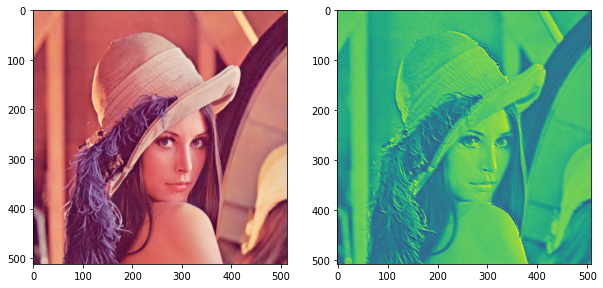

In [15]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
i = img_out[0].numpy().squeeze()
ax1.imshow(i.astype('uint8'));

## 1.4. Inicializando os filtros na mão


A função abaixo inicializa um array de dimensões 5,5,3,3 com todas as posições zero, exceto as posições 5,5,0,0 , 5,5,1,1 e 5,5,2,2 que recebem o valor 1/25.

In [16]:
def my_filter(shape=(5, 5, 3, 3), dtype=None):
    array = np.zeros(shape=shape, dtype=np.float32)
    array[:, :, 0, 0] = 1 / 25
    array[:, :, 1, 1] = 1 / 25
    array[:, :, 2, 2] = 1 / 25
    return array

In [17]:
# transposição apenas para ajudar na visualização
np.transpose(my_filter(), (2, 3, 0, 1))

array([[[[0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04]],

        [[0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ]]],


       [[[0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ]],

        [[0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
      

In [18]:
# a função definida acima é usada para carregar valores nos filtros. 
# use a função my_filter() para pre-inicializar os filtros do objeto conv3. 
# 
conv3 = Sequential([
     Conv2D(filters=3, kernel_size=(5, 5), padding="same",
           input_shape=(None, None, 3), kernel_initializer=my_filter)
])
conv3.output_shape

(None, None, None, 3)

## 1.5. Plote e observe o que aconte com a imagem (1pt)



Foi observada uma redução da nitidez na imagem.

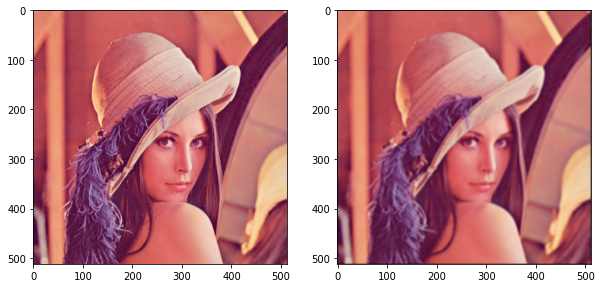

In [19]:
# observe o que aconte com a imagem
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(conv3.predict(img_in)[0].astype('uint8'));

### Responda

**ToDo** : Descreva suas observações sobre a imagem anterior.

A imagem sofreu algum tipo de suavização que reduziu sua nitidez.

## 1.6. Filtros de borda (5pt)

**ToDo** : Crie uma nova função para gerar um filtro de borda nos 3 canais da imagem de entrada. O filtro deve ser 3x3 e ter o formato [[0 0.2 0] [0 -0.2 0] [0 0 0]] (2pt)

In [20]:
def my_new_filter(shape=(1, 3, 3, 3), dtype=None):
    array = np.zeros(shape=shape, dtype=np.float32)
    m = [[0, 0.2, 0], [0, -0.2, 0], [0, 0, 0]]
    array[:, 0] = m.copy()
    array[:, 1] = m.copy()
    array[:, 2] = m.copy()
    return array


In [21]:
my_new_filter()

array([[[[ 0. ,  0.2,  0. ],
         [ 0. , -0.2,  0. ],
         [ 0. ,  0. ,  0. ]],

        [[ 0. ,  0.2,  0. ],
         [ 0. , -0.2,  0. ],
         [ 0. ,  0. ,  0. ]],

        [[ 0. ,  0.2,  0. ],
         [ 0. , -0.2,  0. ],
         [ 0. ,  0. ,  0. ]]]], dtype=float32)

Inicialize o objeto conv4 com seu novo filtro e aplique na imagem de entrada

In [22]:
conv4 = Sequential([
    Conv2D(filters=3, kernel_size=(5, 5), padding="same",
           input_shape=(None, None, 3), kernel_initializer=my_new_filter)
])
conv4.output_shape

(None, None, None, 3)

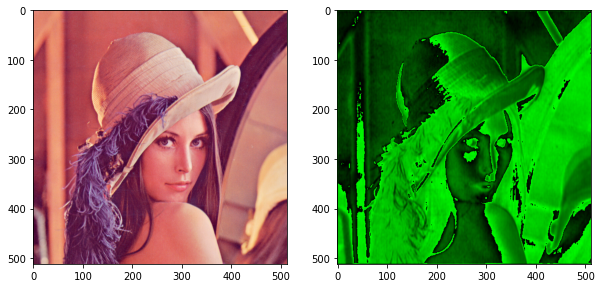

In [23]:
# Plote as duas iamgens lado a lado (filtrada e não filtrada)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(conv4.predict(img_in)[0].astype('uint8'));

## 1.7. Pooling (14pt)



Aplique um max-pooling na imagem, com uma janela de 2x2. Faça com stride de 2 e observe o resultado na imagem de saída. 

In [24]:
# cria um objeto Sequencial de nome max_pool, apenas contendo uma camada de tf.keras.layer.MaxPool2D.
# lembre-se de colocar o parametro input-shape como input_shape=(None, None, 3)

max_pool = Sequential( # ToDo ...
                    [
                        MaxPool2D(strides=2, input_shape=(None, None, 3))                  
                    ])


In [25]:
img_in = np.expand_dims(sample_image, 0) # expande a imagem
img_out = max_pool.predict(img_in) # aplica o pooling

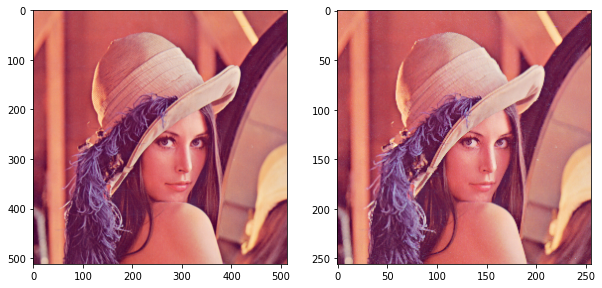

In [26]:
# plota as imagens lado a lado
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

Aumente o stride para 4, repita o processo e observe o resultado na imagem de saída.




In [27]:
# cria um objeto Sequencial de nome max_pool, apenas contendo uma camada de tf.keras.layer.MaxPool2D.
# lembre-se de colucar o parametro input-shape como input_shape=(None, None, 3)
# Coloque o parametro stride para 4

max_pool2 = Sequential( # ToDo ...
                      [
                        MaxPool2D(strides=4, input_shape=(None, None, 3))                  
                      ])

In [28]:
img_in = np.expand_dims(sample_image, 0) # expande a imagem
img_out = max_pool2.predict(img_in) # aplica o pooling

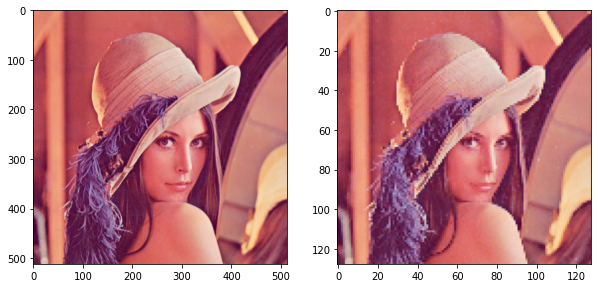

In [29]:
# plota as imagens lado a lado
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

Aumente o stride para 8, repita o processo e observe o resultado na imagem de saída. A

In [30]:
# cria um objeto Sequencial de nome max_pool, apenas contendo uma camada de tf.keras.layer.MaxPool2D.
# lembre-se de colucar o parametro input-shape como input_shape=(None, None, 3)
# Coloque o parametro stride para 8

max_pool3 = Sequential( # ToDo ...
                       [
                        MaxPool2D(strides=8, input_shape=(None, None, 3))                  
                       ])

In [31]:
img_in = np.expand_dims(sample_image, 0) # expande a imagem
img_out = max_pool3.predict(img_in) # aplica o pooling

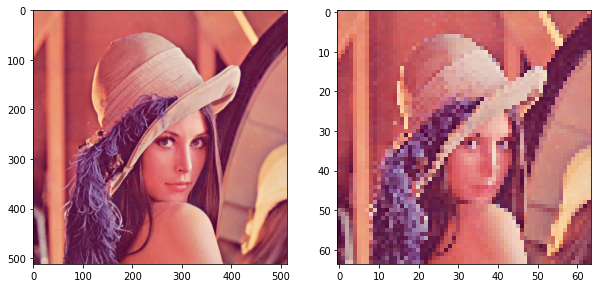

In [32]:
# plota as imagens lado a lado
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

### Responda

**ToDo** - Descreva o que aconteceu com o aumento do stride.

A imagem ficou desfocada, pois com o Max Pooling é extraído as características mais relevantes da imagem, mas com o aumento do stride, a janela que se desloca pela imagem fica maior, ou seja, a partir de muitos pixels vai ser escolhido só um para representa-los, para cada janela, e com o aumento dessa janela (stride) mais pixels ainda vão ser generalizados em um único pixel por janela, gerando um desfoque(borrado) na imagem.

# 2. Reconhecimento de Faces usando uma rede de convolução (20pt)




O objetivo desta etapa é classificar faces na base ORL (AT&T) Database (40 individuos x 10 imagens, de resolução 92x112 pixels e 256 níveis de cinza).

Baixe as imagens no site http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html ou da pasta dataset do Drive.

## 2.1. Preparando os dados (5pt)

In [33]:
# carregue as imagens 

# inicializa matrizes X e y
X = np.empty([400, 112, 92]) # 40 classe com 10 imgs cada, 10304 = 112x92
y = np.empty([400, 1])

# percorre todos os diretorios da base att e carrega as imagens
imgs_path = "/content/drive/My Drive/AttFaces"
i=0
class_id = 0
for f in os.listdir(imgs_path): 
    #print(f)
    if f.startswith("s"):
        class_id = class_id + 1
        for img_path in os.listdir(os.path.join(imgs_path,f)):
            if img_path.endswith(".pgm"):
                #print(img_path)
                X[i, :, :] = io.imread(os.path.join(imgs_path,f,img_path))
                y[i, :] = class_id        
                i = i + 1
 

print("dimensões da matriz X = " , X.shape)

dimensões da matriz X =  (400, 112, 92)


In [34]:
# Divida os dados em treino e teste (70%-30%) com a função train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size= 0.3) #Todo : complete

In [35]:
X_train.shape

(280, 112, 92)

In [36]:
X_test.shape

(120, 112, 92)

## 2.2. Implementando a rede (15pt)

Implemente uma rede de convolução simples, contendo 3 camadas de convolução seguidas de camadas max-pooling. Duas camadas densas (totalemtne conectadas) no final e por fim uma camada com ativação softmax para a classificação. Escolha filtros de tamanhos variados : (3,3) ou (5,5). Para cada camada, crie de 32 a 96 filtros. 
Na camada densa, use de 64 a 200 neurônios.

Use o comando model.summary() para conferir a arquitetura. 

In [37]:
# Implementa uma rede de convolução simples, chamada model

input_size = (X.shape[1], X.shape[2],1)
n_classes = 40

model = models.Sequential()

model.add(layers.InputLayer(input_shape=input_size)) # ToDo ...


model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same")) # Todo ...
model.add(layers.MaxPooling2D(strides=2)) # Todo ..

model.add(layers.Conv2D(filters=96, kernel_size=(5, 5), padding="same")) # Todo ...
model.add(layers.MaxPooling2D(strides=2)) # Todo ..

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same")) # Todo ...
model.add(layers.MaxPooling2D(strides=2)) # Todo ..

# ToDo : adicionar as outras camadas

model.add(layers.Flatten()) # não esqueça da camada flatten ..

model.add(layers.Dense(200, name='CamadaDensa1'))# Todo ..
model.add(layers.Dense(64, name='CamadaDensa2'))# Todo ..

model.add(layers.Dense(40, activation='softmax', name='CamadaClassificacao')) # Todo: softmax
                       
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 112, 92, 32)       832       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 46, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 46, 96)        76896     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 23, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 23, 32)        27680     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 11, 32)      

Seu modelo deve ter uma saída aproximadamente como abaixo:



```
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_60 (Conv2D)           (None, 110, 90, 32)       320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 55, 45, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 53, 43, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 26, 21, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 24, 19, 64)        36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 29184)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                1867840   
_________________________________________________________________
dense_10 (Dense)             (None, 40)                2600      
=================================================================
Total params: 1,926,184
Trainable params: 1,926,184
Non-trainable params: 0
_________________________________________________________________
```



In [38]:
# repare bem o shape de x_train. A priumeira dimensão é o tamanho do lote, a segunda e terceira são referentes ao taamnho das imagens.
# repare que as imagens desta base tem apenas uma banda (escala de cinza) 
X_train.shape

(280, 112, 92)

In [39]:
# Como o tensor acima não contempla o tamanho de canais (no caso , igual a 1), deve-se expandir a última dimensão para deixar a entrada compatĩvel com o que é esperado pelo modelo do tf.keras
X_train_new = np.expand_dims(X_train, 0)  # Todo ..
X_test_new = np.expand_dims(X_test, 0) # Todo ..

X_train_new.shape

(1, 280, 112, 92)

In [40]:
# o vetor de rótulos não precisa ter duas diemnões.
y_train_new = y_train.squeeze()
y_test_new = y_test.squeeze()

# e deve ficar na faixa entre 0 e 39
y_train_new = y_train_new - 1; 
y_test_new = y_test_new - 1;

Compile o modelo usando o método de otimização=adam e função de custo (loss) = sparse_categorical_crossentropy. 

In [41]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])# Todo ...

Treine o modelo por 30 épocas com batch_size = 100.

In [42]:
history = model.fit(X_train, y_train_new, epochs=30, batch_size=100, validation_data=(X_test, y_test_new))# Todo ...

Epoch 1/30
3/3 [==============================] - 12s 4s/step - loss: 389.2213 - accuracy: 0.0214 - val_loss: 1257.8041 - val_accuracy: 0.0250
Epoch 2/30
3/3 [==============================] - 11s 4s/step - loss: 1244.9413 - accuracy: 0.0393 - val_loss: 887.5231 - val_accuracy: 0.0167
Epoch 3/30
3/3 [==============================] - 11s 4s/step - loss: 420.6442 - accuracy: 0.0286 - val_loss: 353.8322 - val_accuracy: 0.0250
Epoch 4/30
3/3 [==============================] - 11s 4s/step - loss: 310.5588 - accuracy: 0.0214 - val_loss: 227.6187 - val_accuracy: 0.0333
Epoch 5/30
3/3 [==============================] - 11s 4s/step - loss: 181.0013 - accuracy: 0.0321 - val_loss: 291.5298 - val_accuracy: 0.0167
Epoch 6/30
3/3 [==============================] - 11s 4s/step - loss: 205.6602 - accuracy: 0.0143 - val_loss: 167.5728 - val_accuracy: 0.0417
Epoch 7/30
3/3 [==============================] - 11s 4s/step - loss: 140.6936 - accuracy: 0.0321 - val_loss: 157.9782 - val_accuracy: 0.0250
Epoc

O retorno da função fit() é um objeto para armazenar o histõrico do treino.

In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Plote a acurácia e o custo (loss) do treino e da validação.

4/4 - 1s - loss: 1.4651 - accuracy: 0.7500 - 1s/epoch - 291ms/step


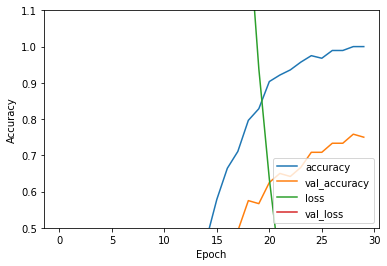

In [44]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test_new, verbose=2)

In [45]:
print(test_acc)

0.75


# 3. Usando um modelo Pré-treinado : VGG (10pt)

Carregando os dados da base AT&T para o VGG. Como a base está em escala de cinza e a entrada do modelo VGG espera uma imagem colorida (RGB), vamos repetir a mesma imagem em cada uma das bandas.

## 3.1. Preparando os dados (2pt)


In [46]:
# inicializa matrizes X e y
X = np.empty([400, 112, 92, 3]) # 40 classe com 10 imgs cada, 10304 = 112x92
y = np.empty([400, 1])

# percorre todos os diretorios da base att e carrega as imagens
imgs_path = "/content/drive/My Drive/AttFaces"
i=0
class_id = 0
for f in os.listdir(imgs_path): 
    #print(f)
    if f.startswith("s"):
        class_id = class_id + 1
        for img_path in os.listdir(os.path.join(imgs_path,f)):
            if img_path.endswith(".pgm"):
                #print(img_path)
                # copia msg imagem para os 3 canais
                X[i, :, :,0] = io.imread(os.path.join(imgs_path,f,img_path))
                X[i, :, :,1] = io.imread(os.path.join(imgs_path,f,img_path))
                X[i, :, :,2] = io.imread(os.path.join(imgs_path,f,img_path))
                y[i, :] = class_id-1        
                i = i + 1
 
       

In [47]:
# divida em 70% treino e 30% teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size= 0.3) # Todo ...
X_train.shape

(280, 112, 92, 3)

## 3.2. Carregando o VGG direto da biblioteca do tensorflow (2pt)

In [48]:
# https://www.tensorflow.org/guide/keras/functional?hl=pt_br

from tensorflow.keras.applications import VGG19
vgg19 = VGG19()

574726144/574710816 [==============================] - 3s 0us/step


In [49]:
vgg19.summary() # repare a quantidade de parãmetros!

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Vamos descartar as duas últimas camadas do VGG

In [50]:
# https://www.tensorflow.org/guide/keras/functional?hl=pt_br
from tensorflow.keras.models import Model

vgg_face_descriptor = Model(inputs=vgg19.layers[0].input, outputs=vgg19.layers[-2].output)

In [51]:
vgg_face_descriptor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Responda

**ToDo** - Por que descartamos as duas últimas camadas do VGG?

Porque as últimas camadas identificam os objetos como um todo, além de fazerem a predição. Portanto, deve-se adicionar a última camada com a sua própria função de ativação e a quantidade de classes que possui seu modelo.

## 3.3 Medindo Similaridade

### As funções abaixo servem para medir similaridade entre duas imagens, passando-se um vetor de características.

In [52]:
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

### A função verifyFace recebe duas imagens e calcula a similaridade entre elas. Se a similaridade for menor que epsilon, afirma-se que as duas imagens são de uma mesma pessoa.

In [53]:
epsilon = 0.0040

def verifyFace(img1, img2):
    
    img1_representation = vgg_face_descriptor.predict(img1, steps=None)[0,:]
    img2_representation = vgg_face_descriptor.predict(img2, steps=None)[0,:]
    
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    
    print("Similaridade com distancia do cosseno: ",cosine_similarity)
    print("Similaridade com distancia euclideana: ",euclidean_distance)
    
    if(cosine_similarity < epsilon):
        print("Verificado! Mesma pessoa!")
    else:
        print("Não-verificado! Não são a mesma pessoa!")
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(np.squeeze(img1))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(np.squeeze(img2))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")

### Verificando a similaridade entre imagens (6pt)

Para 4 pares de imagens da base da AT&T e faça uma verificação entre elas, chamando a função verifyFace().

Antes de usar o VGG como um extrator de caracteristicas, normalize os dados dividindo os pixels por 255. Além disso, re-escalone as imagesn para o formato 224x224. Use a biblioteca OpenCV (cv2). 

Faça para os pares : 64 e 33, 3 e 7, 40 e 44, 100 e 200.

Similaridade com distancia do cosseno:  0.00783073902130127
Similaridade com distancia euclideana:  5.724641
Não-verificado! Não são a mesma pessoa!


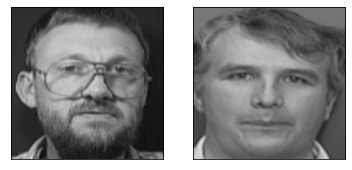

-----------------------------------------
Similaridade com distancia do cosseno:  0.004165530204772949
Similaridade com distancia euclideana:  4.262821
Não-verificado! Não são a mesma pessoa!


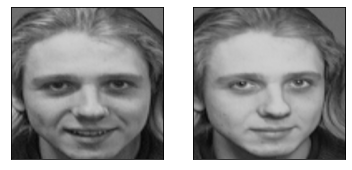

-----------------------------------------
Similaridade com distancia do cosseno:  0.0007703304290771484
Similaridade com distancia euclideana:  1.8124928
Verificado! Mesma pessoa!


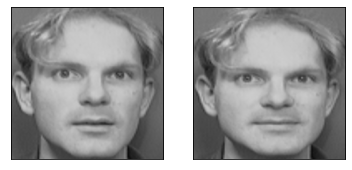

-----------------------------------------
Similaridade com distancia do cosseno:  0.007486701011657715
Similaridade com distancia euclideana:  5.6268773
Não-verificado! Não são a mesma pessoa!


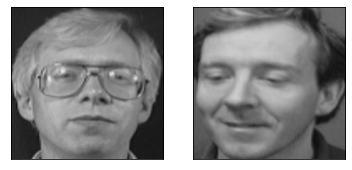

-----------------------------------------


In [54]:
import cv2

# Ajuste as imagens para a entrada do modelo VGG

# exemplo, para o par 64 e 33 :

# Todo : Normaliza entre 0 e 1 , dividindo por 255
img1 = X[64,:,:,:]/255 # Todo
img2 = X[33,:,:,:]/255 # Todo

img3 = X[3,:,:,:]/255 # Todo
img4 = X[7,:,:,:]/255 # Todo

img5 = X[40,:,:,:]/255 # Todo
img6 = X[44,:,:,:]/255 # Todo

img7 = X[100,:,:,:]/255 # Todo
img8 = X[200,:,:,:]/255 # Todo

# Redimensione a imagem para (224,224) e coloca a primeira dimensão unitária
img1 = cv2.resize(img1, (224, 224)) # Todo
img2 = cv2.resize(img2, (224,224)) # Todo

img3 = cv2.resize(img3, (224, 224)) # Todo
img4 = cv2.resize(img4, (224,224)) # Todo

img5 = cv2.resize(img5, (224, 224)) # Todo
img6 = cv2.resize(img6, (224,224)) # Todo

img7 = cv2.resize(img7, (224, 224)) # Todo
img8 = cv2.resize(img8, (224,224)) # Todo

# lembre-se de expandir a primeira dimensão, pois nosso lote aqui é de 1 imagem
img1 = np.expand_dims(img1, 0) # Todo ..
img2 = np.expand_dims(img2, 0) # Todo ..

img3 = np.expand_dims(img3, 0) # Todo ..
img4 = np.expand_dims(img4, 0) # Todo ..

img5 = np.expand_dims(img5, 0) # Todo ..
img6 = np.expand_dims(img6, 0) # Todo ..

img7 = np.expand_dims(img7, 0) # Todo ..
img8 = np.expand_dims(img8, 0) # Todo ..

verifyFace(img1, img2)
verifyFace(img3, img4)
verifyFace(img5, img6)
verifyFace(img7, img8)

# 4. Transferência de aprendizado (50pt)


Estude o tutorial do [link](https://www.tensorflow.org/tutorials/images/transfer_learning) e aplique o mesmo procedimento para ajustar um modelo previamente treinado com imagens da imagenet. 
Use o MobileNetV2 como modelo base.

Faça o procedimento em duas etapas:


1.   Congele todas as camadas exceto as novas que você adicionou ao modelo. Treine.
2.   Libere todas as camadas para o treinamento e treine novamente com um Learning Rate bem pequeno (um décimo do realizado no ítem 1).

In [55]:
# Usando o mobileNet, as imagens devem ter entrada de 160x160x3 e normalizadas entre 0 e 1. 
# Use a funçao abaixo para fazer o trabalho, conjuntamente com tf.data.Dataset.from_tensor_slices

IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [56]:
X_train.shape

(280, 112, 92, 3)

In [57]:
# Tensorflow tem funções especĩficas para carregar os dados. Veja tf.data.Dataset

raw_train = tf.data.Dataset.from_tensor_slices((X_train,y_train))
raw_test = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [58]:
train = raw_train.map(format_example)
test = raw_test.map(format_example)

Seus dados devem ter o formato :



```
TensorShape([Dimension(280), Dimension(160), Dimension(160), Dimension(3)])

```



In [61]:
SHUFFLE_BUFFER_SIZE = 280
BATCH_SIZE = 280

In [184]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

## 4.1. Execute os passos (35pt):




1. Carregue o modelo pré-treinado do MobileNet, remova a última camada. 
2. Adicione uma camdada de Global Average Pooling 2D (GAP)
3. Adicione uma camada densa para ajustar ao seu número de classes e use ativação softmax
4. Use função de custo loss='sparse_categorical_crossentropy'
5. Dentre os dados de treinamento, reserve 10% para validação do modelo.
6. Treine por 10 épocas.
7. Plote os gráficos de custo do treino e validação


In [194]:
# To Do
# Carregar o modelo
model_MobileNet = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')

In [115]:
model_MobileNet.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_11[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [116]:
# Remover última camada
model_MobileNet = Model(inputs=model_MobileNet.layers[0].input, outputs=model_MobileNet.layers[-1].output)

In [117]:
model_MobileNet.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_11[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']        

In [195]:
# Adicione uma camdada de Global Average Pooling 2D (GAP)
# Adicione uma camada densa para ajustar ao seu número de classes e use ativação softmax
from keras.layers import Dense, GlobalAveragePooling2D

x = model_MobileNet.output
x = GlobalAveragePooling2D()(x)
preds = Dense(40,activation='softmax')(x)

In [196]:
model_MobileNet_new = Model(inputs=model_MobileNet.input,outputs=preds)

In [197]:
model_MobileNet_new.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_12[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']        

In [198]:
# Use função de custo loss='sparse_categorical_crossentropy'
from tensorflow.keras import optimizers

model_MobileNet_new.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

In [226]:
# Dentre os dados de treinamento, reserve 10% para validação do modelo.

#validate_ds = packed_ds.take(N_VALIDATION).cache()
#train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()
a = list(train_batches)


validation_batches_new = (np.array(a[0][0][:28]), np.array(a[0][1][:28]))
train_batches_new = (np.array(a[0][0][28:]), np.array(a[0][1][28:]))

In [227]:
# Treine por 10 épocas.
history = model_MobileNet_new.fit(train_batches_new[0], train_batches_new[1], epochs=10, validation_data=validation_batches_new)# Todo ...

Epoch 1/10
8/8 [==============================] - 27s 3s/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 4.5216 - val_accuracy: 0.0714
Epoch 2/10
8/8 [==============================] - 26s 3s/step - loss: 0.0116 - accuracy: 0.9960 - val_loss: 3.5637 - val_accuracy: 0.3214
Epoch 3/10
8/8 [==============================] - 25s 3s/step - loss: 0.0228 - accuracy: 0.9960 - val_loss: 5.0396 - val_accuracy: 0.1071
Epoch 4/10
8/8 [==============================] - 25s 3s/step - loss: 0.0245 - accuracy: 0.9960 - val_loss: 5.4536 - val_accuracy: 0.1786
Epoch 5/10
8/8 [==============================] - 25s 3s/step - loss: 0.0579 - accuracy: 0.9841 - val_loss: 6.1331 - val_accuracy: 0.1429
Epoch 6/10
8/8 [==============================] - 27s 3s/step - loss: 0.0923 - accuracy: 0.9683 - val_loss: 8.7571 - val_accuracy: 0.1429
Epoch 7/10
8/8 [==============================] - 27s 3s/step - loss: 0.0858 - accuracy: 0.9683 - val_loss: 10.8571 - val_accuracy: 0.0714
Epoch 8/10
8/8 [=================

In [ ]:
# Plote os gráficos de custo do treino e validação

In [228]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

8/8 - 3s - loss: 16.9052 - accuracy: 0.0754 - 3s/epoch - 435ms/step


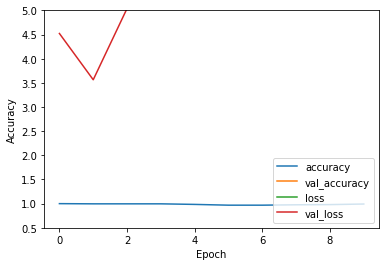

In [234]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 5])
plt.legend(loc='lower right')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 5])
plt.legend(loc='lower right')

test_loss, test_acc = model_MobileNet_new.evaluate(train_batches_new[0],  train_batches_new[1], verbose=2)

## 4.2. Fazendo testes (13pt)

Analize os gráficos. Você provavelmente deve ter observado overfitting. 
Aplique algumas regularizações no modelo, para tentar reduzir o super-ajuste.



1.   Dropout, antes da camada densa, de 50%
2.   Regularização nos pesos da camada densa (L1 ou L2)
3.   Dropout antes da camada de GAP



Veja exemplos no [link](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)

In [240]:
from tensorflow.keras import regularizers
# To Do
# Carregar o modelo
model_MobileNet = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')

# Remover última camada
model_MobileNet = Model(inputs=model_MobileNet.layers[0].input, outputs=model_MobileNet.layers[-1].output)


# Dropout, antes da camada densa, de 50%
# Regularização nos pesos da camada densa (L1 ou L2)
# Dropout antes da camada de GAP
# Adicione uma camdada de Global Average Pooling 2D (GAP)
# Adicione uma camada densa para ajustar ao seu número de classes e use ativação softmax

x = model_MobileNet.output
x = layers.Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
preds = Dense(40,kernel_regularizer=regularizers.l2(0.0001), activation='softmax')(x)
model_MobileNet_new = Model(inputs=model_MobileNet.input,outputs=preds)


In [241]:
# Diminuir Learn Rating
model_MobileNet_new.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [242]:
model_MobileNet_new.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_15[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']        

In [243]:
# Treine por 10 épocas.
history = model_MobileNet_new.fit(train_batches_new[0], train_batches_new[1], epochs=10, validation_data=validation_batches_new)# Todo ...

Epoch 1/10
8/8 [==============================] - 32s 3s/step - loss: 4.2887 - accuracy: 0.0516 - val_loss: 4.5451 - val_accuracy: 0.0357
Epoch 2/10
8/8 [==============================] - 24s 3s/step - loss: 2.7997 - accuracy: 0.2937 - val_loss: 4.4011 - val_accuracy: 0.0357
Epoch 3/10
8/8 [==============================] - 24s 3s/step - loss: 1.8283 - accuracy: 0.5516 - val_loss: 4.2683 - val_accuracy: 0.0357
Epoch 4/10
8/8 [==============================] - 24s 3s/step - loss: 1.2133 - accuracy: 0.7778 - val_loss: 4.1371 - val_accuracy: 0.0357
Epoch 5/10
8/8 [==============================] - 24s 3s/step - loss: 0.7233 - accuracy: 0.9365 - val_loss: 4.0490 - val_accuracy: 0.0357
Epoch 6/10
8/8 [==============================] - 26s 3s/step - loss: 0.4633 - accuracy: 0.9444 - val_loss: 3.9967 - val_accuracy: 0.0714
Epoch 7/10
8/8 [==============================] - 24s 3s/step - loss: 0.3260 - accuracy: 0.9841 - val_loss: 3.9694 - val_accuracy: 0.0714
Epoch 8/10
8/8 [==================

In [244]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

8/8 - 4s - loss: 3.5049 - accuracy: 0.0714 - 4s/epoch - 443ms/step


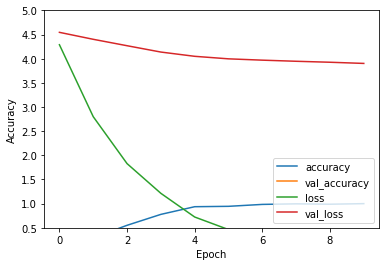

In [245]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 5])
plt.legend(loc='lower right')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 5])
plt.legend(loc='lower right')

test_loss, test_acc = model_MobileNet_new.evaluate(train_batches_new[0],  train_batches_new[1], verbose=2)

In [246]:
# Deixando learn rating padrão
model_MobileNet_new.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])
# Treine por 10 épocas.
history = model_MobileNet_new.fit(train_batches_new[0], train_batches_new[1], epochs=10, validation_data=validation_batches_new)# Todo ...


Epoch 1/10
8/8 [==============================] - 33s 4s/step - loss: 0.5509 - accuracy: 0.8810 - val_loss: 4.3310 - val_accuracy: 0.0357
Epoch 2/10
8/8 [==============================] - 24s 3s/step - loss: 0.2589 - accuracy: 0.9603 - val_loss: 3.8132 - val_accuracy: 0.2500
Epoch 3/10
8/8 [==============================] - 24s 3s/step - loss: 0.0868 - accuracy: 0.9762 - val_loss: 4.8077 - val_accuracy: 0.2143
Epoch 4/10
8/8 [==============================] - 24s 3s/step - loss: 0.0460 - accuracy: 0.9960 - val_loss: 5.3823 - val_accuracy: 0.1071
Epoch 5/10
8/8 [==============================] - 24s 3s/step - loss: 0.0271 - accuracy: 1.0000 - val_loss: 5.3666 - val_accuracy: 0.0714
Epoch 6/10
8/8 [==============================] - 25s 3s/step - loss: 0.0214 - accuracy: 1.0000 - val_loss: 5.1008 - val_accuracy: 0.0714
Epoch 7/10
8/8 [==============================] - 24s 3s/step - loss: 0.0151 - accuracy: 0.9960 - val_loss: 4.9806 - val_accuracy: 0.1429
Epoch 8/10
8/8 [==================

8/8 - 3s - loss: 3.6742 - accuracy: 0.2698 - 3s/epoch - 436ms/step


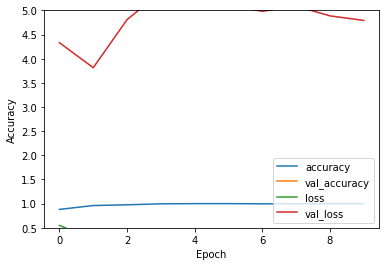

In [247]:
#Plotar os graficos
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 5])
plt.legend(loc='lower right')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 5])
plt.legend(loc='lower right')

test_loss, test_acc = model_MobileNet_new.evaluate(train_batches_new[0],  train_batches_new[1], verbose=2)

### Responda (2pt)

**ToDo** - com qual configuração conseguiu resolver o overfitting?

Nenhum dos modelos MobileNet conseguiu resolver o overfitting pois se ajustaram tão bem ao conjunto de dados conseguindo acurácia de 100%, que não conseguiram acertar quase nada na validação. Porém os modelos da VGGNet conseguiram resolver o Overfitting.

Obs: Para a etapa de validação foram utilizadas 10% dos dados de treinamento, resultando em 28 instâncias.